In [1]:
import matplotlib.pyplot as plt
from scipy.sparse import rand
from tqdm import tqdm
import time
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings("ignore")

from prox import *
from other_func import *
from Algo import *

## Data preparation

In [2]:
# create DCT matrix
m = 128
n = 1024
A = np.zeros((m, n))
for i in range(m):
    for j in range(n):
        A[i][j] = 1/np.sqrt(m)*np.cos(2*(j-1)*np.pi*np.random.uniform(0, 1)/10)
print('before normalization:',1/np.linalg.norm(A,2)**2)
# normalize columns of matrix X
A = normalize(A, axis=0, norm='l2')
print('after normalization:',1/np.linalg.norm(A,2)**2)
corr = A.T.dot(A)
for i in range(1024):
    corr[i][i] = 0

print('coherence:',abs(corr).max())

before normalization: 0.11338344229014033
after normalization: 0.06338152167558278
coherence: 0.9980249725135764


In [3]:
e,v = np.linalg.eig(A.T.dot(A))
maxiter = 20000
error = 1e-5
k_list = np.linspace(4,60,15)
x_index = [i for i in range(n)]

## A recovery instance

using $\lambda = 0.02$, $\sigma = 2$, $\mu = 0.99\mu_{max}$, $k=45$

Running time: 0.46875
relative error: 0.008538825217978937


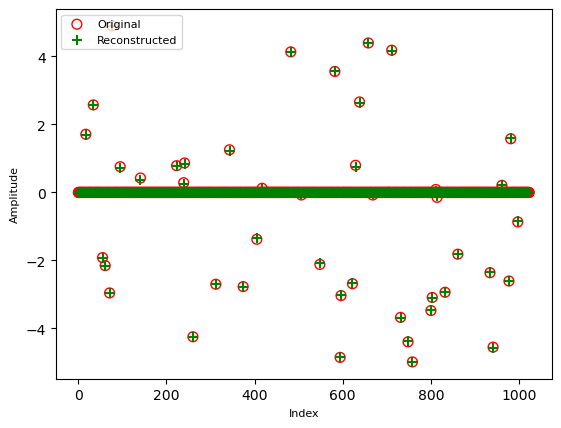

In [4]:
k = 45
Lambda = 0.05
sigma = 2

L=np.linalg.norm(A,2)**2
mu = 0.99*2/(L+Lambda/sigma**2)
for ww in range(100):
    x_true = rand(n,1,k/n).toarray()
    x_true[x_true != 0 ] = 10*(x_true[x_true != 0 ]-0.5)
    b = A.dot(x_true)
    b_noise = b
    Ab = A.T.dot(b_noise)
    AA = A.T.dot(A)
    
    t0 = time.process_time()
    temp = mu*Lambda/sigma**2
    if temp<=1:
        x,i=ISTA(A, b, mu, shrinkage_PiE_soft, sigma, Lambda, maxiter,error)
    else:
        x,i=ISTA(A, b, mu, PiEProximalbyLambertWThreshold, sigma, Lambda, maxiter,error)
    if np.linalg.norm(x-x_true)/np.linalg.norm(x_true)<0.01:
        print("Running time:",time.process_time() - t0)
        print('relative error:',np.linalg.norm(x-x_true)/np.linalg.norm(x_true))
        plt.figure()
        plt.scatter(x_index,x_true,color='none',marker='o' ,label='Original',edgecolors='r', s=50)
        plt.rcParams['figure.dpi'] = 600 #分辨率
        plt.scatter(x_index,x,marker='+',label='Reconstructed',color='g',s=50)
        plt.xlabel('Index',fontsize=8)
        plt.ylabel('Amplitude',fontsize=8)
        plt.legend(loc='upper left',fontsize = 8) 
        plt.show()
        break

## Comparison of 11 Non-Convex Penalty Functions without noise

### under $0.5*\mu_{max}$.



\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|} \hline
Penalties & PiE &Log & CaP & TL1 & SCAD & MCP & \ell_0 & \ell_1 &\ell_{1/2} &\ell_1-\ell_2 &\ell_1/\ell_2 \\ \hline
 &\lambda=0.05  &\lambda=0.02  &\lambda=0.02  &\lambda=0.02  &\lambda=0.2  &\lambda=0.2  &\lambda=0.9 &\lambda=0.02   &\lambda=0.1 &\lambda=0.01 &\lambda=0.01\\  
Parameters  &\sigma=2  &a=1  &a=1 &a=2 &a=20  &a=19  & -  & -   & - &a=1 & -\\  
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{\lambda}{\sigma^2}}
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{\lambda}{a^2}}
           &\mu=0.5\!\frac{2}{\nu_{\max}}
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{2(a+1)\lambda}{a^2}}
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{1}{a-1}}
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{1}{a}}
&\mu=0.5\!\frac{2}{\nu_{\max}}
&\mu=0.5\!\frac{2}{\nu_{\max}}
&\mu=0.5\!\frac{2}{\nu_{\max}}
&\mu=0.5\!\frac{2}{\nu_{\max}+2a}
&\mu=0.5\!\frac{2}{\nu_{\max}}
\\ \hline
\end{array}


In [4]:
shrinkage_list = [_,_,_,shrinkage_TL1,shrinkage_hard,shrinkage_soft,shrinkage_half,shrinkage_scad,shrinkage_mcp,shrinkage_l1_2,shrinkage_l1overl2]
#               PiE   Log   cap   TL1    hard  soft   half  scad   mcp   L1-L2    L1/L2
lambda_list = [0.05, 0.02, 0.02 , 0.02,  0.9 , 0.01,   0.1 , 0.2,  0.2 , 0.01 ,  0.2 ]
a_list      = [ 2  ,   1 ,   1  ,  3  ,   0  ,   0 ,   0   , 20 ,  19  ,  1   ,   0  ]
mu_ = 0.5

# set \mu_{max}
mu_pie = mu_*(2/(max(e).real+lambda_list[0]/(a_list[0]**2)))
mu_scad= mu_*(2/(max(e).real+1/(a_list[7]-1)))
mu_mcp = mu_*(2/(max(e).real+1/(a_list[8])))
mu_log = mu_*(2/(max(e).real+lambda_list[1]/(a_list[1]**2)))
mu_tl1 = mu_*(2/(max(e).real+2*(a_list[3]+1)*lambda_list[3]/(a_list[3]**2)))
mu_L1_L2 = mu_*(2 / (max(e).real+2*a_list[9]))
mu     = mu_*(2 / max(e).real)

mu_list = [mu_pie,mu_log,mu,mu_tl1,mu,mu,mu,mu_scad,mu_mcp,mu_L1_L2,mu]
k_list = np.linspace(4,60,15)
x_index = [i for i in range(n)]

avgtime_5 = np.zeros((len(k_list),len(shrinkage_list)))
success_5 = np.zeros((len(k_list),len(shrinkage_list)))
numiter_5 = np.zeros((len(k_list),len(shrinkage_list)))

for index_k, k in enumerate(k_list):
    p = k/n
    
    total_time = np.zeros((1,len(shrinkage_list)))
    total_num = np.zeros((1,len(shrinkage_list)))
    
    for j in tqdm(range(100)):
        x_true = rand(n,1,p).toarray()
        x_true[x_true != 0 ] = 10*(x_true[x_true != 0 ]-0.5)
        b = A.dot(x_true)
        
        #PiE
        t0 = time.process_time()
        temp = mu_pie*lambda_list[0]/a_list[0]**2
        if temp<=1:
            x,num=ISTA(A,b,mu_list[0],shrinkage_PiE_soft,a_list[0],lambda_list[0],maxiter,error)
        else:
            x,num=ISTA(A,b,mu_list[0],PiEProximalbyLambertWThreshold,a_list[0],lambda_list[0],maxiter,error)
        if Error(x,x_true)<0.01:
            success_5[index_k][0] += 0.01
        total_time[0][0] += time.process_time()-t0
        total_num[0][0] += num
        
        #Log
        t0 = time.process_time()
        if np.sqrt(lambda_list[1])<=a_list[1]:
            x,num=ISTA(A,b,mu_list[1],shrinkage_log_soft,a_list[1],lambda_list[1],maxiter,error)
        else:
            x,num=ISTA(A,b,mu_list[1],shrinkage_log_hard,a_list[1],lambda_list[1],maxiter,error) 
        if Error(x,x_true)<0.01:
            success_5[index_k][1] += 0.01
        total_time[0][1] += time.process_time()-t0
        total_num[0][1] += num
        
        #Cap
        t0 = time.process_time()
        if lambda_list[2]<=2*a_list[2]:
            x,num=ISTA(A,b,mu_list[2],shrinkage_CaP_soft,a_list[2],lambda_list[2],maxiter,error)
        else:
            x,num=ISTA(A,b,mu_list[2],shrinkage_CaP_hard,a_list[2],lambda_list[2],maxiter,error)
        if Error(x, x_true)<0.01:
            success_5[index_k][2] += 0.01
        total_time[0][2] += time.process_time()-t0 
        total_num[0][2] += num
        
        for i in range(3,11):
            t0 = time.process_time()
            x,num=ISTA(A,b,mu_list[i],shrinkage_list[i],a_list[i],lambda_list[i],maxiter,error)
            if Error(x, x_true)<0.01:
                success_5[index_k][i] += 0.01
            total_time[0][i] += time.process_time()-t0 
            total_num[0][i] += num
    avgtime_5[index_k] = total_time/100
    numiter_5[index_k] = total_num/100

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [52:48<00:00, 31.69s/it]


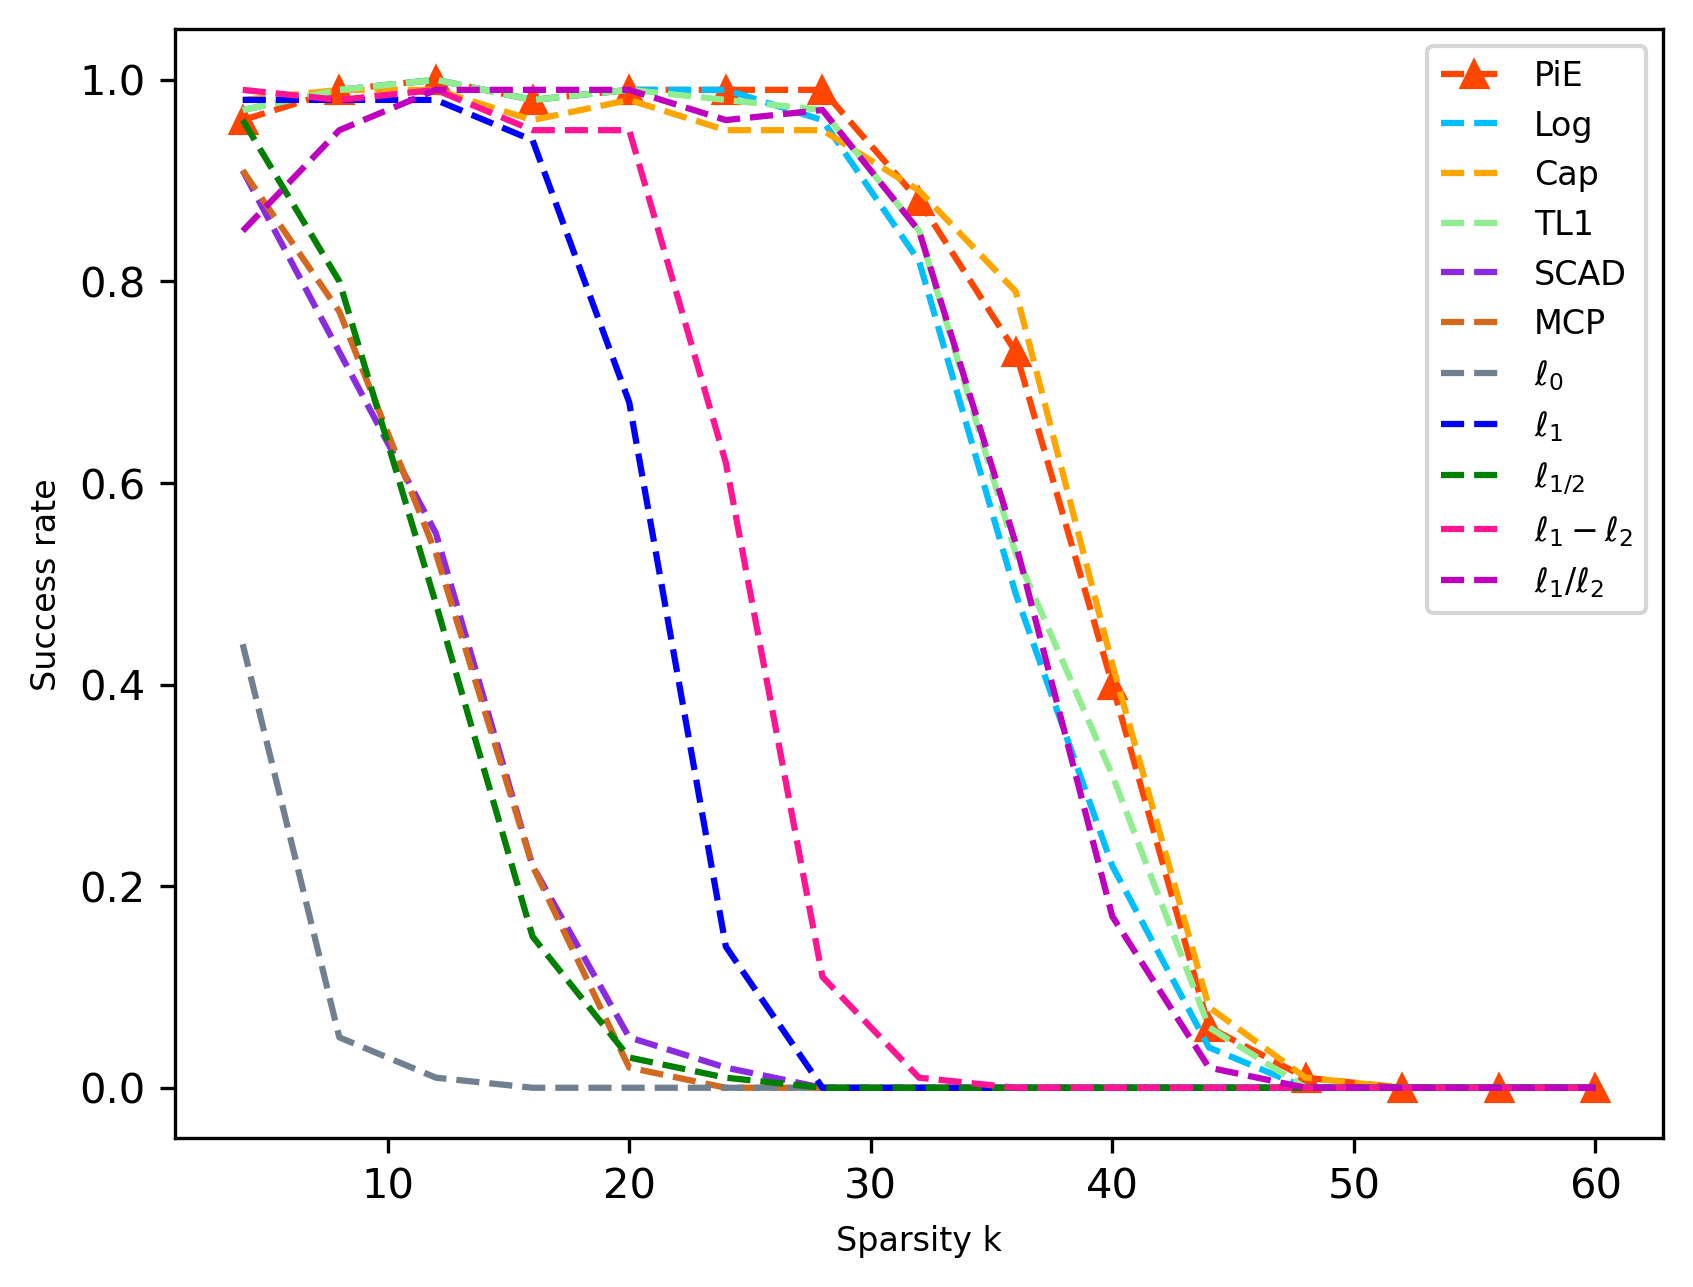

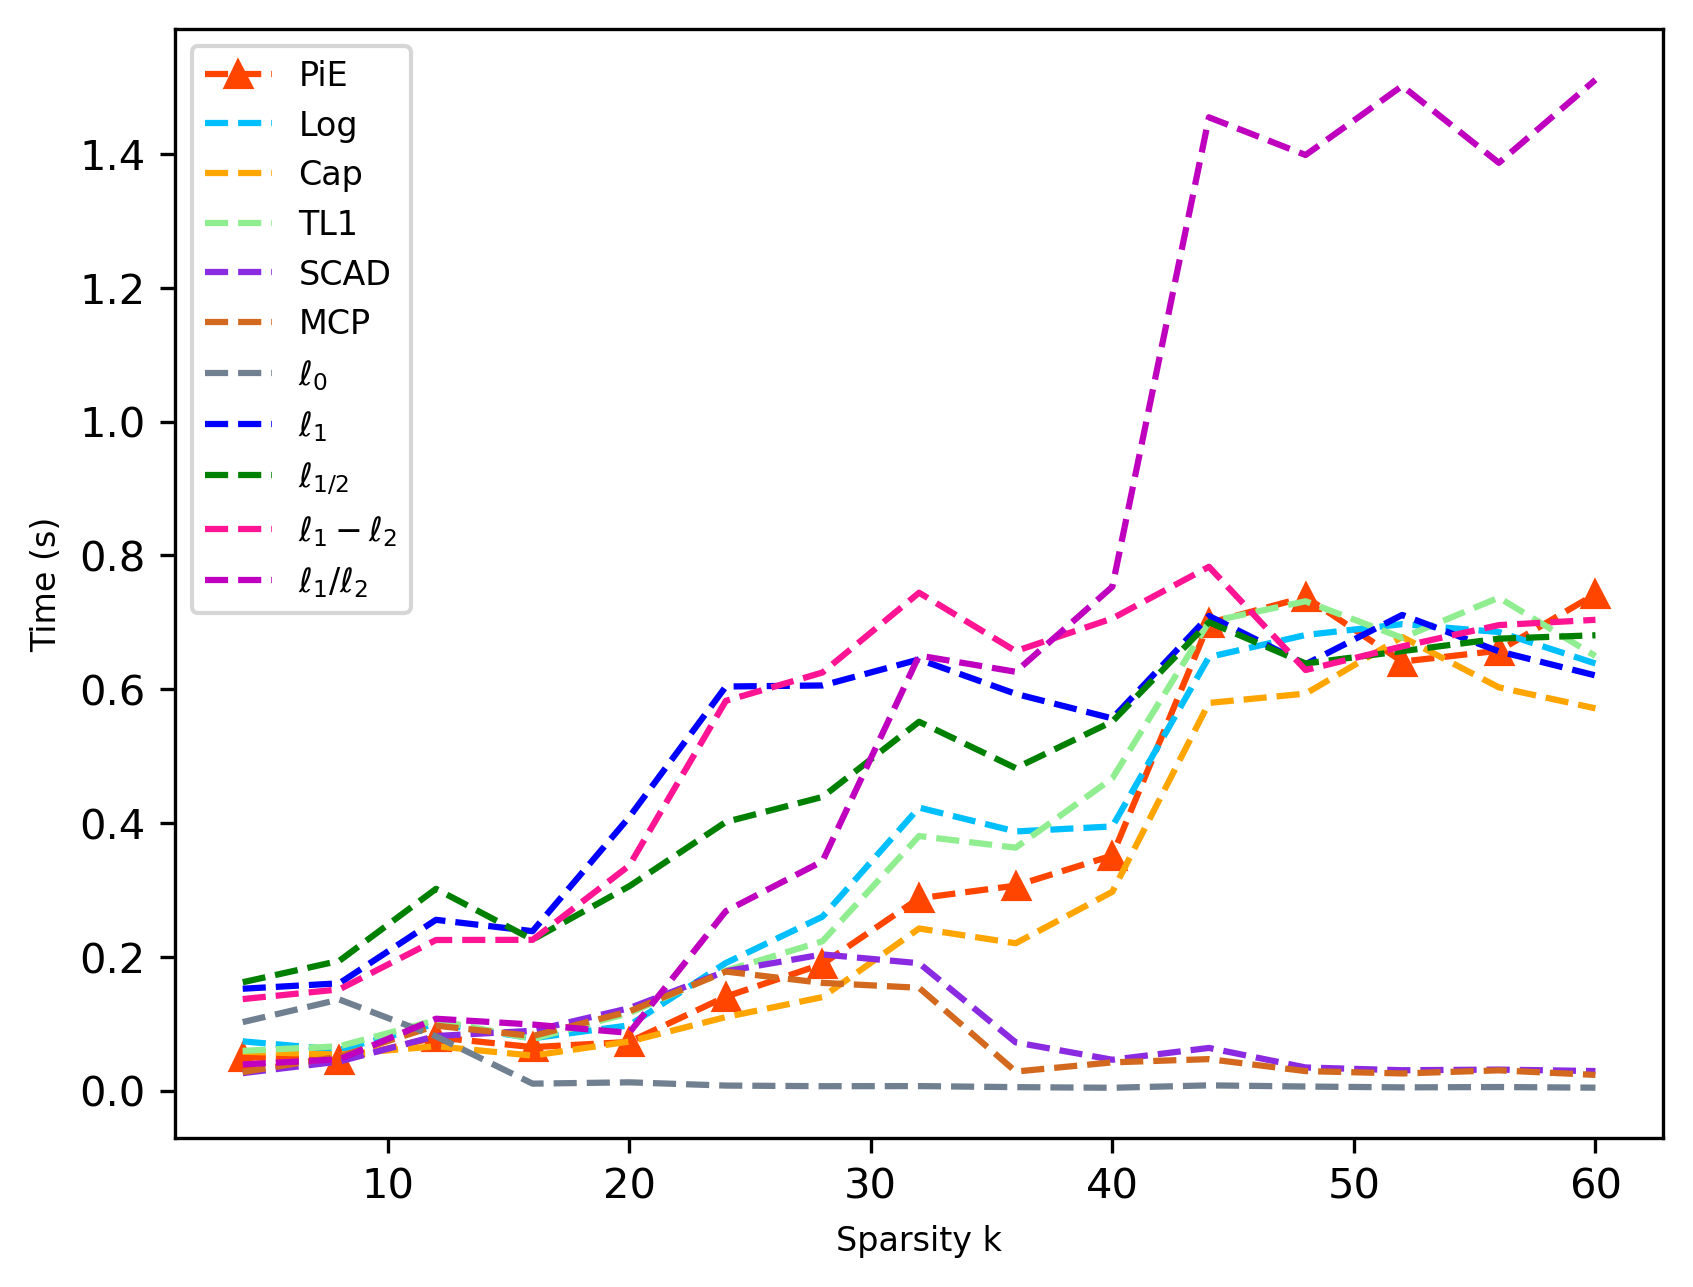

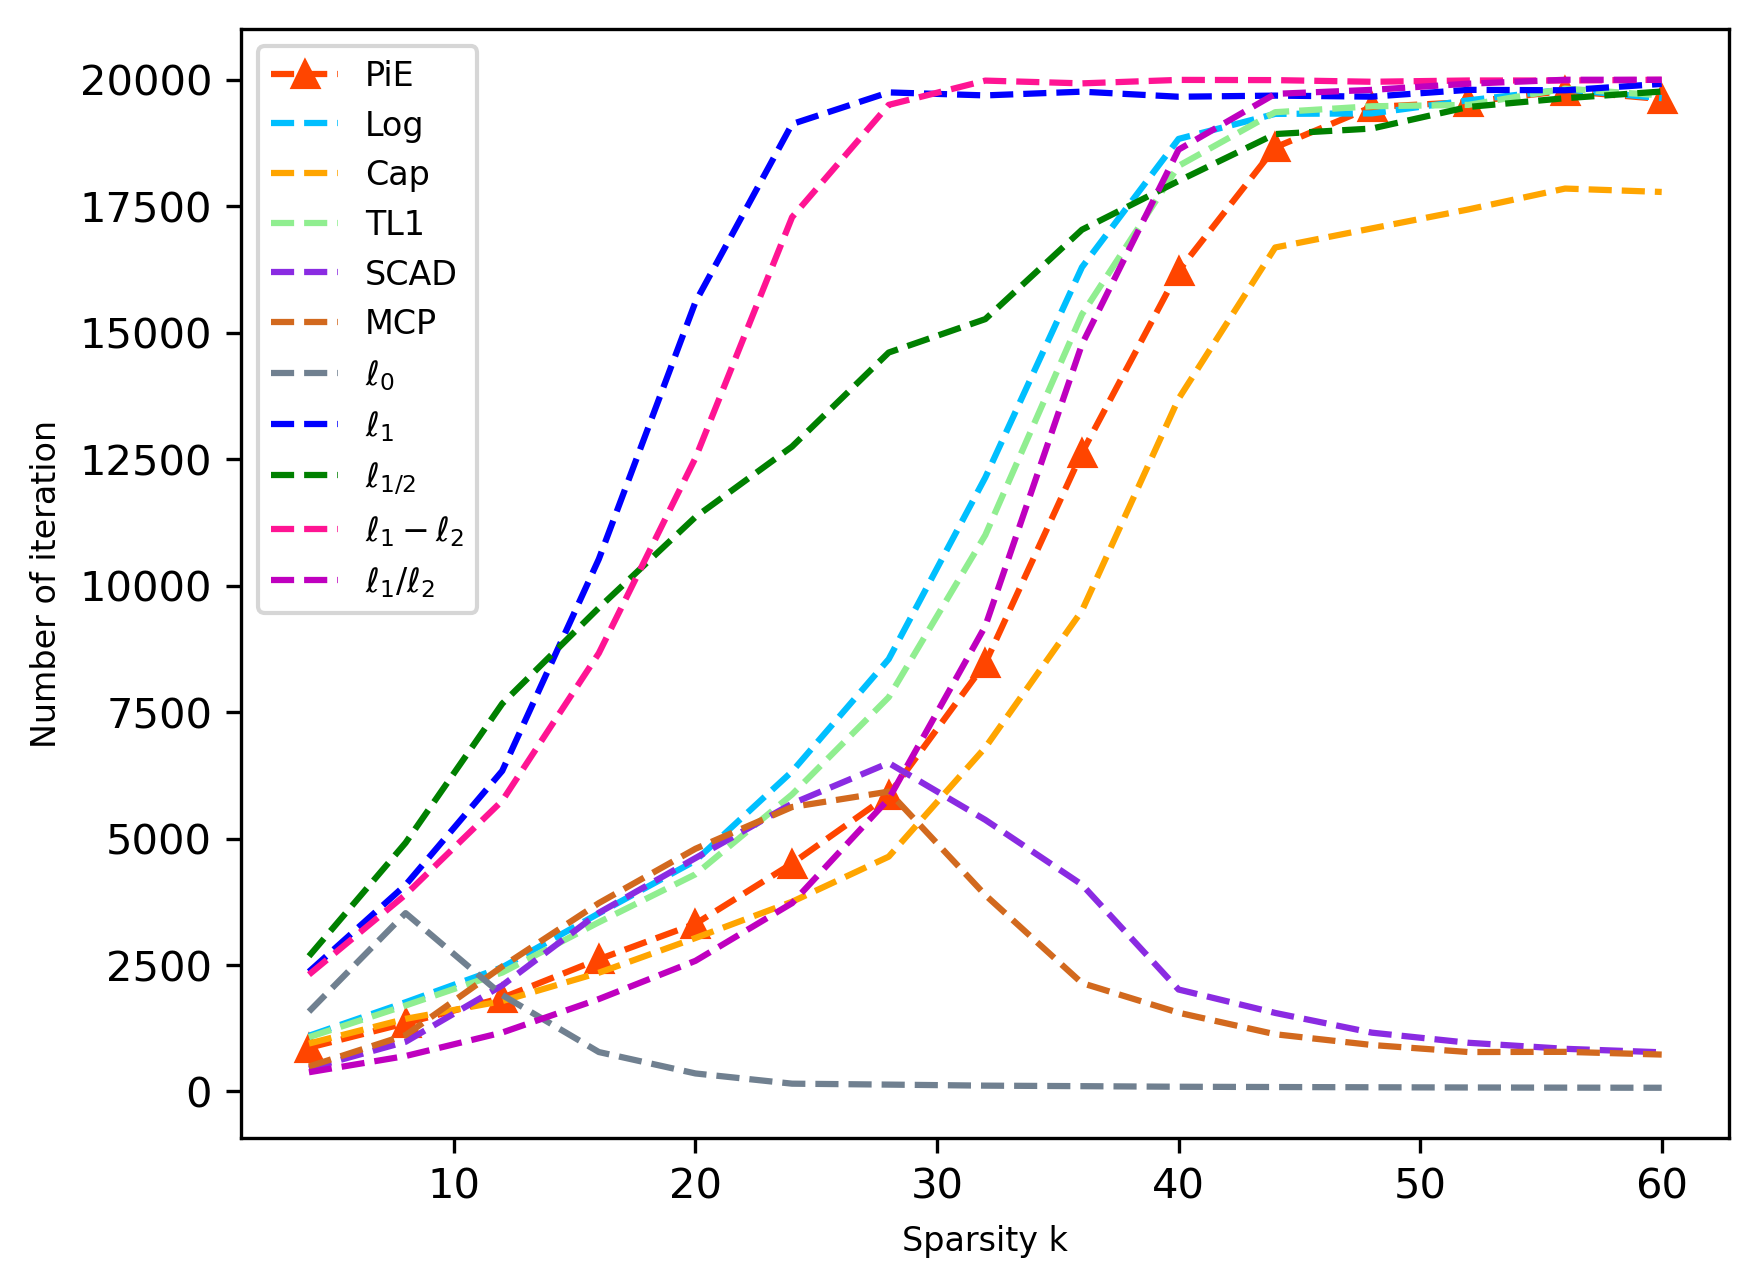

In [79]:
plt.rcParams['figure.dpi'] = 300
color_list = ['orangered','deepskyblue','orange','lightgreen','slategrey','blue','green',
              'blueviolet','chocolate','deeppink','m']
label_list = ['PiE','Log','Cap','TL1','$\ell_0$','$\ell_1$','$\ell_{1/2}$','SCAD','MCP','$\ell_1-\ell_2$','$\ell_1/\ell_2$']
mark_list = ['^',None,None,None,None,None,None,None,None,None,None]

plt.figure()
for i in [0,1,2,3,7,8,4,5,6,9,10]:
    plt.plot(k_list, success_5[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('Success rate',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.show()

plt.figure()
for i in [0,1,2,3,7,8,4,5,6,9,10]:
    plt.plot(k_list, avgtime_5[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('Time (s)',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.show()

plt.figure()
for i in [0,1,2,3,7,8,4,5,6,9,10]:
    plt.plot(k_list, numiter_5[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('Number of iteration',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.show()

### under $0.99*\mu_{max}$.



\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|} \hline
Penalties & PiE &Log & CaP & TL1 & SCAD & MCP & \ell_0 & \ell_1 &\ell_{1/2} &\ell_1-\ell_2 &\ell_1/\ell_2 \\ \hline
 &\lambda=0.05  &\lambda=0.02  &\lambda=0.02  &\lambda=0.02  &\lambda=0.2  &\lambda=0.2  &\lambda=0.9 &\lambda=0.02   &\lambda=0.1 &\lambda=0.01 &\lambda=0.01\\  
Parameters  &\sigma=2  &a=1  &a=1 &a=2 &a=20  &a=19  & -  & -   & - &a=1 & -\\  
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{\lambda}{\sigma^2}}
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{\lambda}{a^2}}
           &\mu=0.5\!\frac{2}{\nu_{\max}}
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{2(a+1)\lambda}{a^2}}
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{1}{a-1}}
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{1}{a}}
&\mu=0.5\!\frac{2}{\nu_{\max}}
&\mu=0.5\!\frac{2}{\nu_{\max}}
&\mu=0.5\!\frac{2}{\nu_{\max}}
&\mu=0.5\!\frac{2}{\nu_{\max}+2a}
&\mu=0.5\!\frac{2}{\nu_{\max}}
\\ \hline
\end{array}


In [5]:
shrinkage_list = [_,_,_,shrinkage_TL1,shrinkage_hard,shrinkage_soft,shrinkage_half,shrinkage_scad,shrinkage_mcp,shrinkage_l1_2,shrinkage_l1overl2]
#               PiE   Log    Cap   TL1   hard  soft   half  scad   mcp   L1-L2    L1/L2
lambda_list = [0.05, 0.02, 0.02 , 0.02,  0.9 , 0.01,   0.1 , 0.2,  0.2 , 0.01 ,  0.2 ]
a_list      = [ 2  ,   1 ,   1  ,  2  ,   0  ,   0 ,   0   , 20 ,  19  ,  1   ,   0  ]
mu_ = 0.99

mu_pie = mu_*(2/(max(e).real+lambda_list[0]/(a_list[0]**2)))
mu_scad= mu_*(2/(max(e).real+1/(a_list[7]-1)))
mu_mcp = mu_*(2/(max(e).real+1/(a_list[8])))
mu_log = mu_*(2/(max(e).real+lambda_list[1]/(a_list[1]**2)))
mu_tl1 = mu_*(2/(max(e).real+2*(a_list[3]+1)*lambda_list[3]/(a_list[3]**2)))
mu_L1_L2 = mu_*(2 /( max(e).real+2*a_list[9]))
mu     = mu_*(2 / max(e).real)

mu_list = [mu_pie,mu_log,mu,mu_tl1,mu,mu,mu,mu_scad,mu_mcp,mu_L1_L2,mu]
k_list = np.linspace(4,60,15)
x_index = [i for i in range(n)]

avgtime_99 = np.zeros((len(k_list),len(shrinkage_list)))
success_99 = np.zeros((len(k_list),len(shrinkage_list)))
numiter_99 = np.zeros((len(k_list),len(shrinkage_list)))
for index_k, k in enumerate(k_list):
    p = k/n
    
    total_time = np.zeros((1,len(shrinkage_list)))
    total_num = np.zeros((1,len(shrinkage_list)))
    for j in tqdm(range(100)):
        x_true = rand(n,1,p).toarray()
        x_true[x_true != 0 ] = 10*(x_true[x_true != 0 ]-0.5)
        b = A.dot(x_true)
        
        #PiE
        t0 = time.process_time()
        temp = mu_pie*lambda_list[0]/a_list[0]**2
        if temp<=1:
            x,num=ISTA(A,b,mu_list[0],shrinkage_PiE_soft,a_list[0],lambda_list[0],maxiter,error)
        else:
            x,num=ISTA(A,b,mu_list[0],PiEProximalbyLambertWThreshold,a_list[0],lambda_list[0],maxiter,error)
        if Error(x,x_true)<0.01:
            success_99[index_k][0] += 0.01
        total_time[0][0] += time.process_time()-t0
        total_num[0][0] += num
        
        #Log
        t0 = time.process_time()
        if np.sqrt(lambda_list[1])<=a_list[1]:
            x,num=ISTA(A,b,mu_list[1],shrinkage_log_soft,a_list[1],lambda_list[1],maxiter,error)
        else:
            x,num=ISTA(A,b,mu_list[1],shrinkage_log_hard,a_list[1],lambda_list[1],maxiter,error) 
        if Error(x,x_true)<0.01:
            success_99[index_k][1] += 0.01
        total_time[0][1] += time.process_time()-t0
        total_num[0][1] += num
        
        #Cap
        t0 = time.process_time()
        if lambda_list[2]<=2*a_list[2]:
            x,num=ISTA(A,b,mu_list[2],shrinkage_CaP_soft,a_list[2],lambda_list[2],maxiter,error)
        else:
            x,num=ISTA(A,b,mu_list[2],shrinkage_CaP_hard,a_list[2],lambda_list[2],maxiter,error)
        if Error(x, x_true)<0.01:
            success_99[index_k][2] += 0.01
        total_time[0][2] += time.process_time()-t0 
        total_num[0][2] += num
        
        for i in range(3,11):
            t0 = time.process_time()
            x,num=ISTA(A,b,mu_list[i],shrinkage_list[i],a_list[i],lambda_list[i],maxiter,error)
            if Error(x, x_true)<0.01:
                success_99[index_k][i] += 0.01
            total_time[0][i] += time.process_time()-t0 
            total_num[0][i] += num
    avgtime_99[index_k] = total_time/100
    numiter_99[index_k] = total_num/100

100%|██████████| 100/100 [51:17<00:00, 30.77s/it]


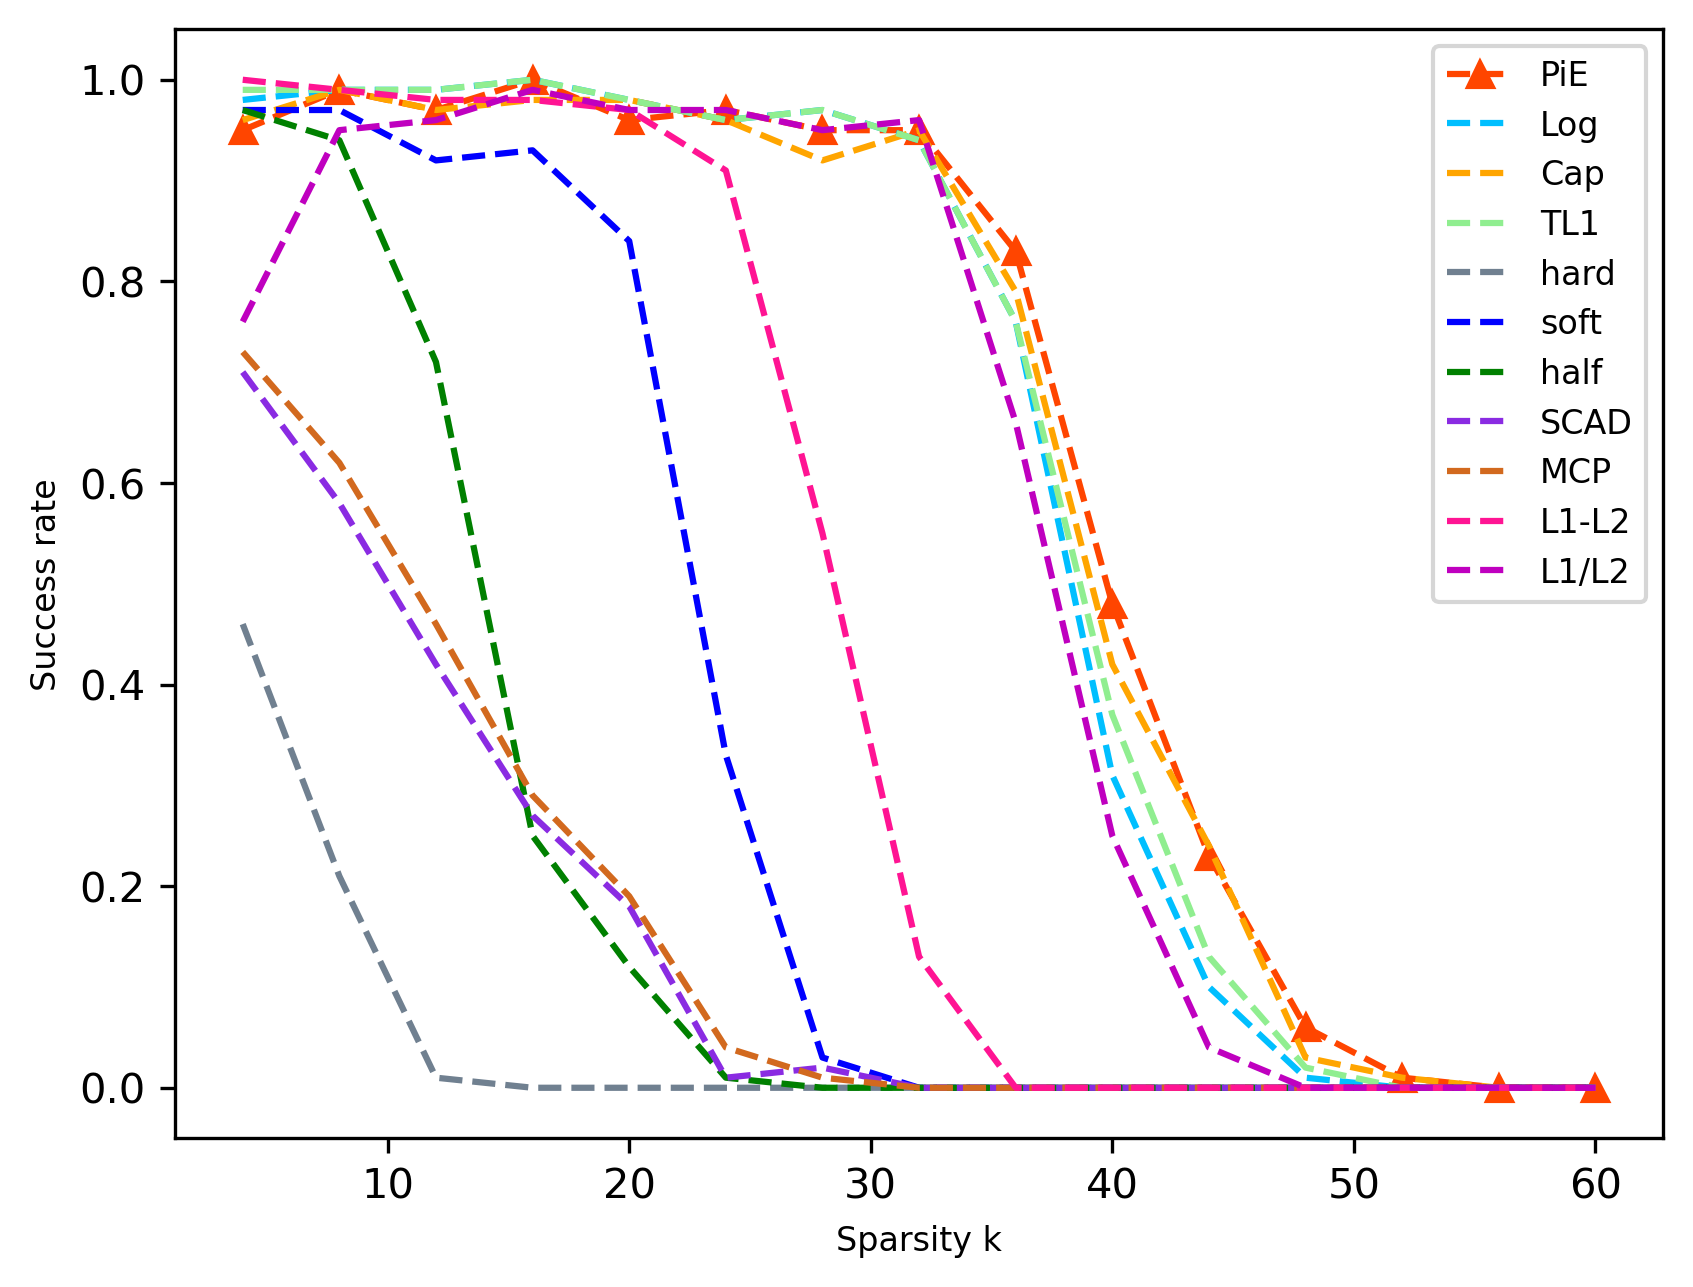

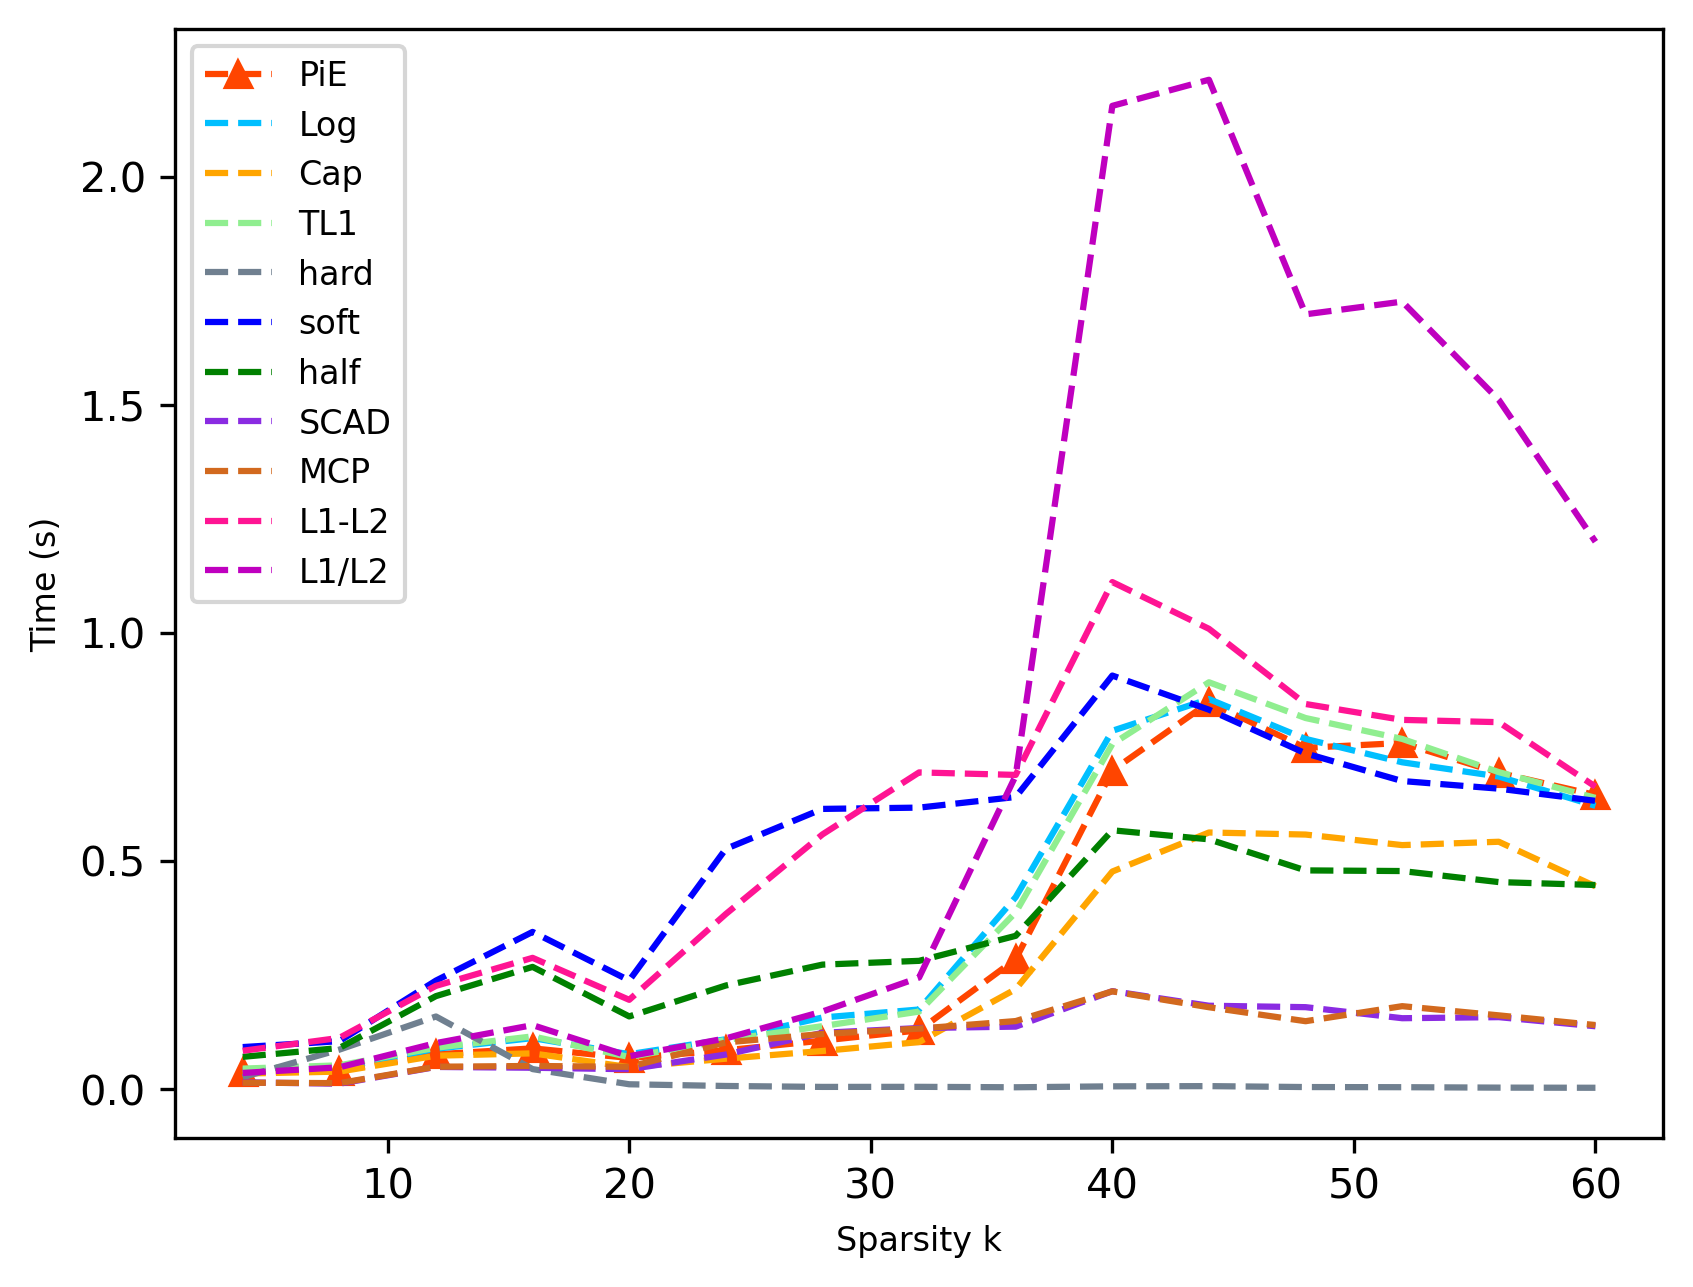

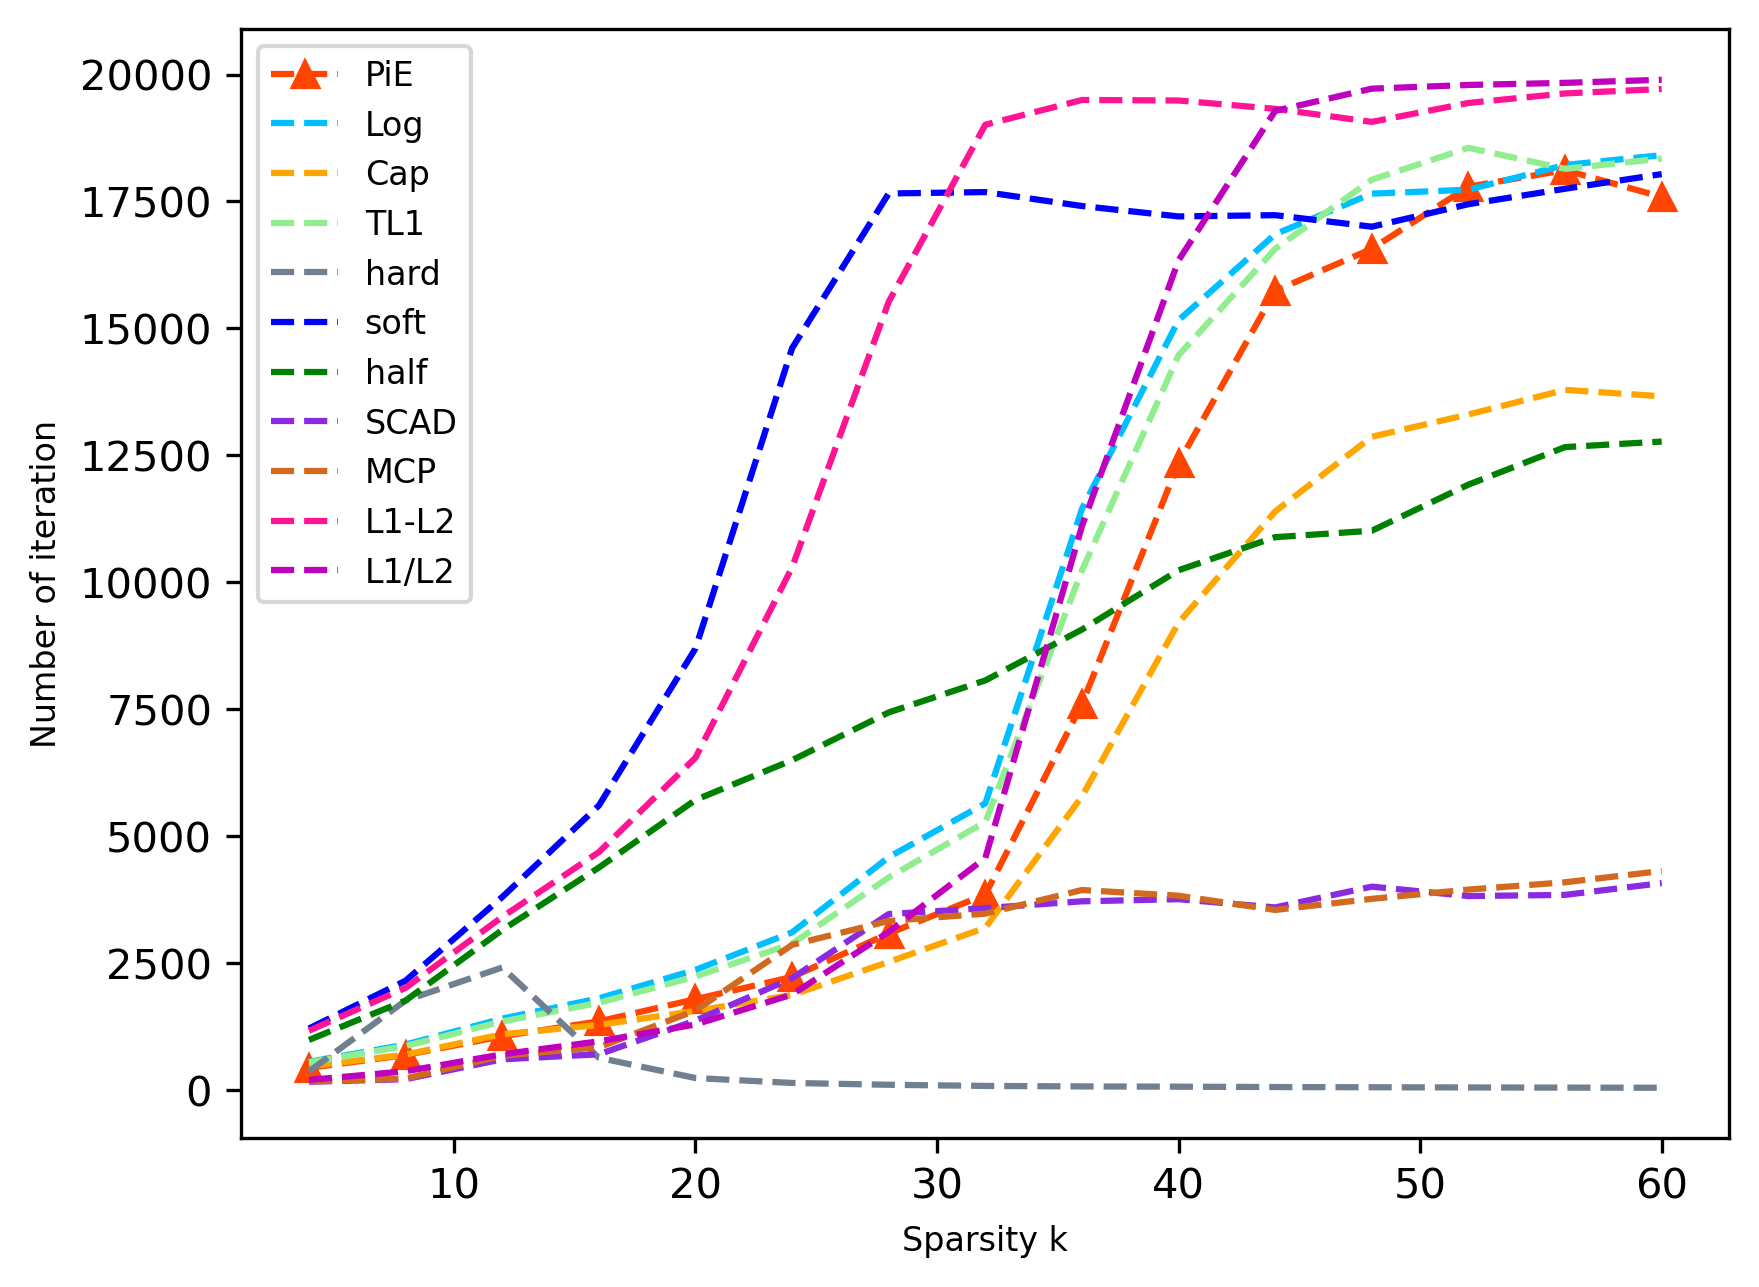

In [6]:
plt.rcParams['figure.dpi'] = 300 #分辨率
color_list = ['orangered','deepskyblue','orange','lightgreen','slategrey','blue','green',
              'blueviolet','chocolate','deeppink','m']
label_list = ['PiE','Log','Cap','TL1','hard','soft','half','SCAD','MCP','L1-L2','L1/L2']
mark_list = ['^',None,None,None,None,None,None,None,None,None,None]

plt.figure()
for i in range(success_99.shape[1]):
    plt.plot(k_list, success_99[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('Success rate',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.show()

plt.figure()
for i in range(avgtime_99.shape[1]):
    plt.plot(k_list, avgtime_99[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('Time (s)',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.show()

plt.figure()
for i in range(numiter_99.shape[1]):
    plt.plot(k_list, numiter_99[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('Number of iteration',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.show()

In [7]:
import pandas as pd
pd.DataFrame(success_99).to_excel('./pic/F10/success_99.xlsx')
pd.DataFrame(avgtime_99).to_excel('./pic/F10/avgtime_99.xlsx')
pd.DataFrame(numiter_99).to_excel('./pic/F10/numiter_99.xlsx')

## Comparison of 11 Non-Convex Penalty Functions with noise

\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|} \hline
Penalties & PiE &Log & CaP & TL1 & SCAD & MCP & \ell_0 & \ell_1 & \ell_{1/2} & \ell_1-\ell_2 & \ell_1/\ell_2 \\ \hline
 &\lambda=0.5  &\lambda=0.2  &\lambda=0.2 &\lambda=0.2  &\lambda=0.2  &\lambda=0.5   &\lambda=0.9 &\lambda=0.2   &\lambda=0.5 &\lambda=0.1 &\lambda=0.5\\  
Parameters  &\sigma=2  &a=1  &a=1 &a=1 &a=20  &a=19  & -  & -   & - &a=1 & -\\  
           &\mu=0.99\!\frac{2}{\nu_{\max}+\frac{\lambda}{\sigma^2}}
           &\mu=0.99\!\frac{2}{\nu_{\max}+\frac{\lambda}{a^2}}
           &\mu=0.99\!\frac{2}{\nu_{\max}}
           &\mu=0.99\!\frac{2}{\nu_{\max}+\frac{2(a+1)\lambda}{a^2}}
           &\mu=0.99\!\frac{2}{\nu_{\max}+\frac{1}{a-1}}
           &\mu=0.99\!\frac{2}{\nu_{\max}+\frac{1}{a}}
&\mu=0.99\!\frac{2}{\nu_{\max}}
&\mu=0.99\!\frac{2}{\nu_{\max}}
&\mu=0.99\!\frac{2}{\nu_{\max}}
&\mu=0.99\!\frac{2}{\nu_{\max}+2a}
&\mu=0.99\!\frac{2}{\nu_{\max}}
\\ \hline
\end{array}

In [7]:
shrinkage_list = [_,_,_,shrinkage_TL1,shrinkage_hard,shrinkage_soft,shrinkage_half,shrinkage_scad,shrinkage_mcp,shrinkage_l1_2,shrinkage_l1overl2]
#               PiE   Log    cap   TL1   hard  soft   half  scad   mcp   L1-L2    L1/L2
lambda_list = [0.5,  0.2 ,  0.2  , 0.2,  0.9 , 0.2,   0.5 , 0.2,  0.5 , 0.1 ,  0.5 ]
a_list      = [ 2  ,   1 ,   1  ,  3  ,   0  ,   0 ,   0   , 20 ,  19  ,  1   ,   0  ]
mu_ = 0.99
mu_pie = mu_*(2/(max(e).real+lambda_list[0]/(a_list[0]**2)))
mu_scad= mu_*(2/(max(e).real+1/(a_list[7]-1)))
mu_mcp = mu_*(2/(max(e).real+1/(a_list[8])))
mu_log = mu_*(2/(max(e).real+lambda_list[1]/(a_list[1]**2)))
mu_tl1 = mu_*(2/(max(e).real+2*(a_list[3]+1)*lambda_list[3]/(a_list[3]**2)))
mu_L1_L2 = mu_*(2 /( max(e).real+2*a_list[9]))
mu     = mu_*(2 / max(e).real)

mu_list = [mu_pie,mu_log,mu,mu_tl1,mu,mu,mu,mu_scad,mu_mcp,mu_L1_L2,mu]
snr_list = [30,25,20,15,10]

p = 20/n
x_index = [i for i in range(n)]

Snr = np.zeros((len(snr_list),len(shrinkage_list)))

for index_s, s in enumerate(snr_list):
    
    snr = np.zeros((1,len(shrinkage_list)))
    for j in tqdm(range(100)):
        x_true = rand(n,1,p).toarray()
        x_true[x_true != 0 ] = 10*(x_true[x_true != 0 ]-0.5)
        b = A.dot(x_true)
        b_noise,noise =add_noise(s,b)
        #PiE
        t0 = time.process_time()
        temp = mu_pie*lambda_list[0]/a_list[0]**2
        if temp<=1:
            x,num=ISTA(A,b_noise,mu_list[0],shrinkage_PiE_soft,a_list[0],lambda_list[0],maxiter,error)
        else:
            x,num=ISTA(A,b_noise,mu_list[0],PiEProximalbyLambertWThreshold,a_list[0],lambda_list[0],maxiter,error)
        A_temp = A[:,x.nonzero()[0]]
        x_db = (np.linalg.inv(A_temp.T.dot(A_temp)).dot(A_temp.T)).dot(b_noise)
        x[x.nonzero()[0]] = x_db
        snr[0][0] += SNR(x,x_true)
        
        #Log
        t0 = time.process_time()
        if np.sqrt(lambda_list[1])<=a_list[1]:
            x,num=ISTA(A,b_noise,mu_list[1],shrinkage_log_soft,a_list[1],lambda_list[1],maxiter,error)
        else:
            x,num=ISTA(A,b_noise,mu_list[1],shrinkage_log_hard,a_list[1],lambda_list[1],maxiter,error) 
        snr[0][1] += SNR(x,x_true)
        
        #Cap
        t0 = time.process_time()
        if lambda_list[2]<=2*a_list[2]:
            x,num=ISTA(A,b_noise,mu_list[2],shrinkage_CaP_soft,a_list[2],lambda_list[2],maxiter,error)
        else:
            x,num=ISTA(A,b_noise,mu_list[2],shrinkage_CaP_hard,a_list[2],lambda_list[2],maxiter,error)
        snr[0][2] += SNR(x,x_true)
        
        for i in range(3,11):
            t0 = time.process_time()
            x,num=ISTA(A,b_noise,mu_list[i],shrinkage_list[i],a_list[i],lambda_list[i],maxiter,error)
            snr[0][i] += SNR(x,x_true)
    Snr[index_s] = snr/100

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:34<00:00,  9.35s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

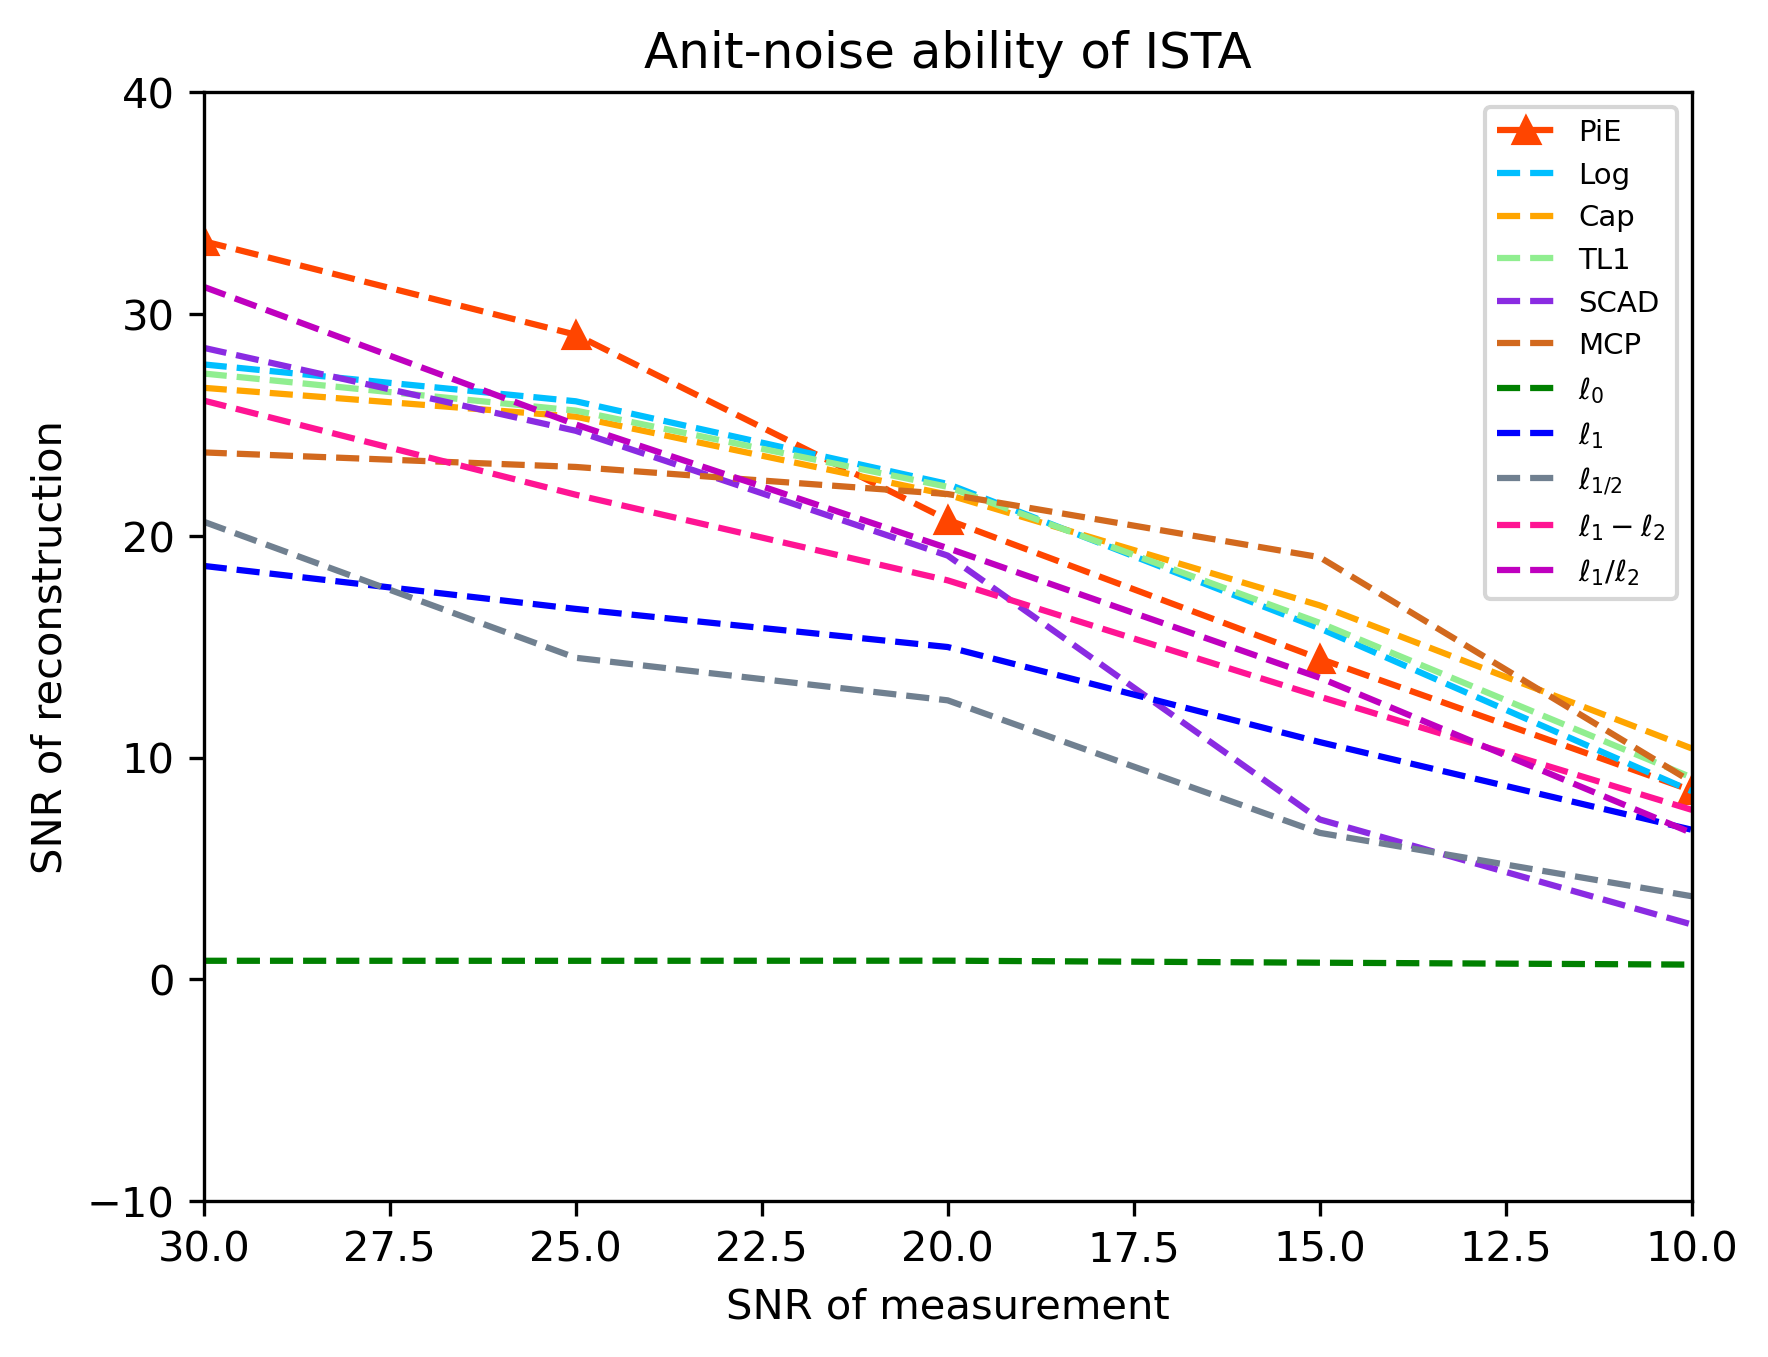

In [9]:
#SNR pic
plt.rcParams['figure.dpi'] = 300 #分辨率
color_list = ['orangered','deepskyblue','orange','lightgreen','green','blue','slategrey',
              'blueviolet','chocolate','deeppink','m']
label_list = ['PiE','Log','Cap','TL1','$\ell_0$','$\ell_1$','$\ell_{1/2}$','SCAD','MCP','$\ell_1-\ell_2$','$\ell_1/\ell_2$']
mark_list = ['^',None,None,None,None,None,None,None,None,None,None]
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.figure()
for i in [0,1,2,3,7,8,4,5,6,9,10]:
    plt.plot(snr_list, Snr[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle='--',marker =mark_list[i] )
plt.ylabel('SNR of reconstruction')
plt.xlabel("SNR of measurement")
plt.ylim((-10,40))
plt.xlim((30,10))
plt.title('Anit-noise ability of ISTA')
plt.legend(loc = 1,fontsize = 7)
# plt.savefig('SNR_incoherent_20.png')
plt.show